# Predicting Insurance Costs With Linear Regression
This project focuses on predicting insurance costs using linear regression. The dataset being used is the Medical Cost Data Set from Kaggle. The dataset contains information on medical insurance bills that are associated with some demographic and personal characteristics of the person who received it.

For this problem, we are interested in how these different characteristics relate to the total medical cost. This is a continuous positive number, so linear regression is a good candidate machine learning model to use.

We want to construct the best predictive model for the cost given information about a patient.

In [35]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## The Dataset

In [54]:
# Reading in the dataset
insurance = pd.read_csv('insurance.csv')
insurance_original = insurance.copy()
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [55]:
# Analyzing the target ('charges') column
print('The average total charge:', insurance['charges'].mean())
print('The median total charge:', insurance['charges'].median())
print('The min total charge:', insurance['charges'].min())
print('The max total charge:', insurance['charges'].max())

The average total charge: 13270.422265141257
The median total charge: 9382.033
The min total charge: 1121.8739
The max total charge: 63770.42801


The mean and median values appear relatively distant from one another, suggesting that the data may be right skewed. Let's analyze further

<AxesSubplot:title={'center':'Histogram of Charges'}, ylabel='Frequency'>

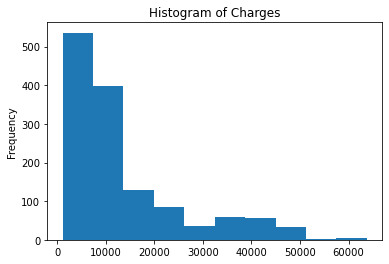

In [56]:
# Plotting histogram of charges
insurance['charges'].plot.hist(title='Histogram of Charges')

As expected, the data is heavily right skewed. This could potential impact our model's performance due to biasing the residuals. Let's try to transform the data to a more normal looking distribution

<AxesSubplot:title={'center':'Histogram of Log Charges'}, ylabel='Frequency'>

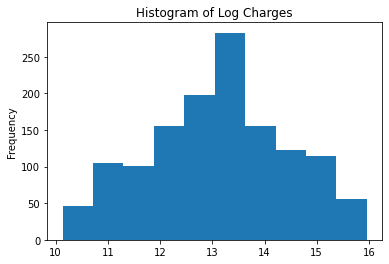

In [57]:
# Transforming charges
insurance["log_charges"] = np.log2(insurance["charges"])
insurance['log_charges'].plot.hist(title='Histogram of Log Charges')

This distribution appears more normal. It may be of interest to run the model on both distributions to see exactly which performs better. It is anticipated that the normal distribution will introduce less bias in the residuals, and therefore will perform better, but we will see.

## Feature Engineering

Text(0.5, 1.0, 'Heatmap of Correlations')

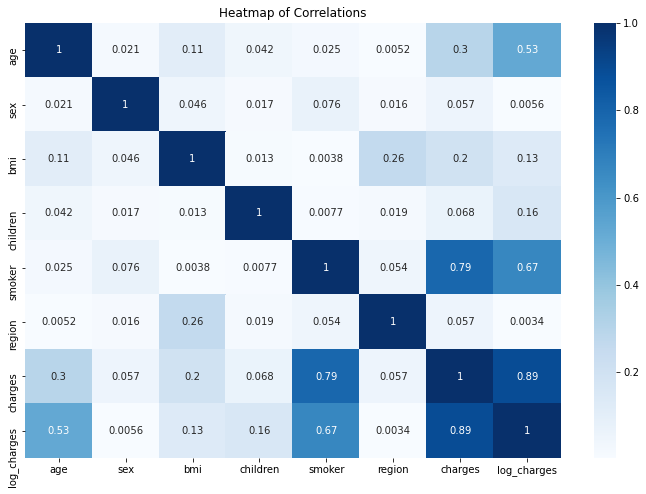

In [58]:
# Transforming categorical features
insurance['sex'] = insurance['sex'].apply(lambda x: 1 if x =='male' else 0)
insurance['smoker'] = insurance['smoker'].apply(lambda x: 1 if x =='yes' else 0)
insurance['region'].replace(to_replace={'northwest': 0, 'northeast': 1, 'southwest': 2, 'southeast': 3}, inplace=True)

# Analyzing Correlations
correlations = abs(insurance.corr())

plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap='Blues')
plt.title('Heatmap of Correlations')

The largest correlations to the charges columns are with 'age', 'bmi', and 'children', and 'smoker'. We can use a subset of features to train the model and compare that to a model trained on all features to see if we can improve performance by dropping features that do not correlate highly with our target.

## Data Preparation
We will first focus on training the model on the entire feature set. Once we have the results of this model, we will create a new model that contains only the largest correlated features listed above for comparison.

In [59]:
# Dividing data into training and test sets

# Extracting feature set
X = insurance.drop(['charges', 'log_charges'], axis=1)

# Extracting targets
y = insurance['charges']
y_log = insurance['log_charges']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=77)

## The Model

Non Transformed Target Column
Intercept: -12320.209601785307
Coefficients: [  263.55126194   -67.99312218   338.72772258   426.1876592
 23757.37922976  -318.75762306]
Log Transformed Target Column
Intercept_log: 10.127772622015929
Coefficients_log: [ 0.04998208 -0.11269385  0.01851786  0.1414682   2.25490047 -0.06131292]


Coefficient of Determination
R2: 0.7510300445506091
R2_log: 0.7709562868304731


Mean-Squared-Error
MSE: 36740015.88403296
MSE_log: 0.40571319642492165


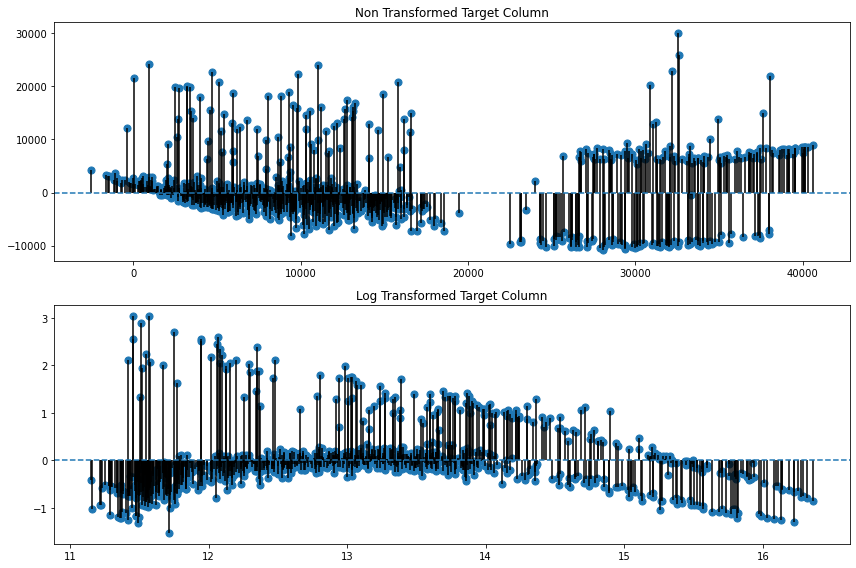

In [117]:
# Fitting the models

model = LinearRegression()
model_log = LinearRegression()

model.fit(X_train, y_train)
model_log.fit(X_train_log, y_train_log)

# Examining coefficients of the models
print('Non Transformed Target Column')
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)
print('Log Transformed Target Column')
print('Intercept_log:', model_log.intercept_)
print('Coefficients_log:', model_log.coef_)
print('\n')

# Predicting training set outcomes
preds = model.predict(X_train)
preds_log = model_log.predict(X_train_log)

# Examining coefficient of determination
R2 = r2_score(y_train, preds)
R2_log = r2_score(y_train_log, preds_log)
print('Coefficient of Determination')
print('R2:', R2)
print('R2_log:', R2_log)
print('\n')

# Mean-Squared-Error
mse = mean_squared_error(y_train, preds)
mse_log = mean_squared_error(y_train_log, preds_log)
print('Mean-Squared-Error')
print('MSE:', mse)
print('MSE_log:', mse_log)

# Plotting Residuals
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(2, 1, 1)
ax1.scatter(preds, y_train-preds, s=50)
ax1.vlines(preds, 0, y_train-preds, color='Black')
ax1.axhline(0, linestyle='--')
ax1.set_title('Non Transformed Target Column')
ax1.xaxis.grid(False)

ax2 = fig.add_subplot(2, 1, 2)
ax2.scatter(preds_log, y_train_log-preds_log, s=50)
ax2.vlines(preds_log, 0, y_train_log-preds_log, color='Black')
ax2.axhline(0, linestyle='--')
ax2.set_title('Log Transformed Target Column')
ax2.xaxis.grid(False)

plt.tight_layout()
plt.show()

We can see that the log transformation improved performance of the model when looking at the R2 values. (NOTE to self: Need to transform log error back to originally scaled data to better understand which is best)

We can also note that the residuals become worse as the charges value increases. This tells us that the model is having a hard time predicting large charges, and is being conservative in its predictions. Further tuning the model with more complex terms (such as quadratics, interactings of features with one another, etc) could help improve this.

## Evaluating Model On Test Data

In [118]:
# Predicting values of test data
test_pred = model.predict(X_test)
test_pred_log = model_log.predict(X_test_log)

# Calculating MSE
test_mse = mean_squared_error(y_test, test_pred)
test_mse_log = mean_squared_error(y_test_log, test_pred_log)
print('Test MSE:', test_mse)
print('Test MSE Log:', test_mse_log)

Test MSE: 35990547.35916092
Test MSE Log: 0.4340637803096528
